In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# change path if your file is elsewhere
DATA_PATH = "C:/Users/fatim/Downloads/Dataset_Identify customer segments for online retail with the use of K-means clustering/Online Retail.xlsx"

# Load Excel (adjust sheet_name if necessary)
df = pd.read_excel(DATA_PATH, sheet_name=0)

print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(10)


Loaded dataframe shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [27]:
import os
os.environ["OMP_NUM_THREADS"] = "1"   # safe, prevents the MKL/OMP thread issue on Windows
print("OMP_NUM_THREADS set to", os.environ["OMP_NUM_THREADS"])

OMP_NUM_THREADS set to 1


In [29]:
# Basic info

print("\n--- INFO ---")
df.info()

print("\n--- DESCRIBE (numeric) ---")
display(df.describe().T.round(3))

# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().mean()*100).round(2).sort_values(ascending=False)
print("\n--- MISSING COUNTS (top) ---")
print(missing.head(20))
print("\n--- MISSING % (top) ---")
print(missing_percent.head(20))

# Duplicates
print("\nDuplicate rows:", df.duplicated().sum())

# Unique values per column (helpful for categorical understanding)
print("\nUnique values (sample):")
for col in ['StockCode','Description','Country','InvoiceNo','CustomerID']:
    if col in df.columns:
        print(col, "->", df[col].nunique())



--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

--- DESCRIBE (numeric) ---


,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303



--- MISSING COUNTS (top) ---
CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

--- MISSING % (top) ---
CustomerID     24.93
Description     0.27
InvoiceNo       0.00
StockCode       0.00
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
Country         0.00
dtype: float64

Duplicate rows: 5268

Unique values (sample):
StockCode -> 4070
Description -> 4223
Country -> 38
InvoiceNo -> 25900
CustomerID -> 4372


In [7]:
# Clean the data (concise, reusable)
def clean_retail_data(df, drop_na_customer=True, drop_refunds=False, remove_non_positive_total=True):
    """
    Clean online retail DataFrame.
    - drop_na_customer: drop rows where CustomerID is NaN (recommended for customer-level analysis)
    - drop_refunds: drop refund/return rows (InvoiceNo starts with 'C' or negative qty/price)
    - remove_non_positive_total: drop rows with TotalPrice <= 0
    Returns cleaned DataFrame and a small diagnostics dict.
    """
    data = df.copy()
    
    # Ensure InvoiceDate is datetime (usually already is)
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
    
    # Flag refunds/returns
    data['is_refund'] = (
        data['InvoiceNo'].astype(str).str.startswith('C') |
        (data['Quantity'] < 0) |
        (data['UnitPrice'] < 0)
    )

    diag = {}
    diag['initial_shape'] = df.shape
    diag['initial_duplicates'] = df.duplicated().sum()
    diag['initial_missing_customerid'] = df['CustomerID'].isnull().sum()

    # Drop rows without CustomerID if requested
    if drop_na_customer and 'CustomerID' in data.columns:
        before = data.shape[0]
        data = data.dropna(subset=['CustomerID'])
        diag['dropped_no_customerid'] = before - data.shape[0]
    else:
        diag['dropped_no_customerid'] = 0

    # Remove exact duplicates
    before = data.shape[0]
    data = data.drop_duplicates()
    diag['dropped_duplicates'] = before - data.shape[0]

    # Fix dtypes now that NaNs are handled
    if 'CustomerID' in data.columns:
        # safe cast: some CustomerID may be floats like 15287.0
        data['CustomerID'] = data['CustomerID'].astype(int)

    data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce').fillna(0).astype(int)
    data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce').fillna(0.0
    # TotalPrice for monetary checks
    data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

    # Optionally drop refunds/returns
    if drop_refunds:
        before = data.shape[0]
        data = data[~data['is_refund']]
        diag['dropped_refunds'] = before - data.shape[0]
    else:
        diag['dropped_refunds'] = 0

    # Optionally remove non-positive totals (zero or negative)
    if remove_non_positive_total:
        before = data.shape[0]
        data = data[data['TotalPrice'] > 0]
        diag['dropped_non_positive_total'] = before - data.shape[0]
    else:
        diag['dropped_non_positive_total'] = 0

    # Some quick anomaly stats
    diag['final_shape'] = data.shape
    diag['refund_flagged_rows'] = int(data['is_refund'].sum())
    diag['quantity_min_max'] = (int(data['Quantity'].min()), int(data['Quantity'].max()))
    diag['unitprice_min_max'] = (float(data['UnitPrice'].min()), float(data['UnitPrice'].max()))
    diag['totalprice_min_max'] = (float(data['TotalPrice'].min()), float(data['TotalPrice'].max()))
    
    return data, diag

# Run cleaning with recommended defaults (drop rows without CustomerID, keep refunds for now)
data, diag = clean_retail_data(df, drop_na_customer=True, drop_refunds=False, remove_non_positive_total=True)

# Print compact diagnostics
print("Initial shape:", diag['initial_shape'])
print("Dropped rows without CustomerID:", diag['dropped_no_customerid'])
print("Dropped exact duplicates:", diag['dropped_duplicates'])
print("Dropped refunds (if any requested):", diag['dropped_refunds'])
print("Dropped non-positive totals:", diag['dropped_non_positive_total'])
print("Final shape:", diag['final_shape'])
print("Refund-flagged rows in final data:", diag['refund_flagged_rows'])
print("Quantity min/max:", diag['quantity_min_max'])
print("UnitPrice min/max:", diag['unitprice_min_max'])
print("TotalPrice min/max:", diag['totalprice_min_max'])

# Show a few of the most suspicious rows for quick inspection
print("\nTop 5 by Quantity:")
display(data.sort_values('Quantity', ascending=False).head(5)[['InvoiceNo','StockCode','Description','Quantity','UnitPrice','TotalPrice','CustomerID','Country','is_refund']])

print("\nTop 5 by UnitPrice:")
display(data.sort_values('UnitPrice', ascending=False).head(5)[['InvoiceNo','StockCode','Description','Quantity','UnitPrice','TotalPrice','CustomerID','Country','is_refund']])




Initial shape: (541909, 8)
Dropped rows without CustomerID: 135080
Dropped exact duplicates: 5225
Dropped refunds (if any requested): 0
Dropped non-positive totals: 8912
Final shape: (392692, 10)
Refund-flagged rows in final data: 0
Quantity min/max: (1, 80995)
UnitPrice min/max: (0.001, 8142.75)
TotalPrice min/max: (0.001, 168469.6)

Top 5 by Quantity:


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,TotalPrice,CustomerID,Country,is_refund
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,168469.60,16446,United Kingdom,False
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60,12346,United Kingdom,False
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,0.21,1008.00,12901,United Kingdom,False
206121,554868,22197,SMALL POPCORN HOLDER,4300,0.72,3096.00,13135,United Kingdom,False
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,0.82,3202.92,18087,United Kingdom,False



Top 5 by UnitPrice:


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,TotalPrice,CustomerID,Country,is_refund
173382,551697,POST,POSTAGE,1,8142.75,8142.75,16029,United Kingdom,False
422376,573080,M,Manual,1,4161.06,4161.06,12536,France,False
422351,573077,M,Manual,1,4161.06,4161.06,12536,France,False
406406,571751,M,Manual,1,3949.32,3949.32,12744,Singapore,False
374542,569382,M,Manual,1,3155.95,3155.95,15502,United Kingdom,False


Outlier capping applied on: ['Quantity', 'UnitPrice', 'TotalPrice']

Quantity:
  q_low: 1.0
  q_high: 120.0
  before_min: 1
  before_max: 80995
  after_min: 1
  after_max: 120

UnitPrice:
  q_low: 0.21
  q_high: 14.95
  before_min: 0.001
  before_max: 8142.75
  after_min: 0.21
  after_max: 14.95

TotalPrice:
  q_low: 0.55
  q_high: 203.52
  before_min: 0.001
  before_max: 168469.6
  after_min: 0.55
  after_max: 203.52


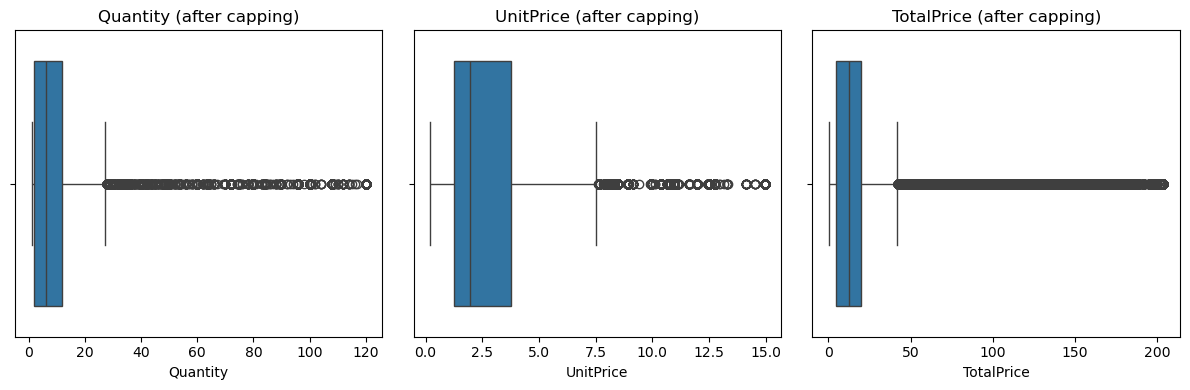

In [11]:
# Handle outliers by capping at 1st–99th percentile

def cap_outliers(df, cols, lower_q=0.01, upper_q=0.99):
    """
    Cap values in given columns between the lower_q and upper_q percentiles.
    Returns a new DataFrame and a diagnostics dict with before/after ranges.
    """
    capped = df.copy()
    diag = {}
    
    for col in cols:
        if col in capped.columns:
            q_low = capped[col].quantile(lower_q)
            q_high = capped[col].quantile(upper_q)
            
            before_min, before_max = capped[col].min(), capped[col].max()
            capped[col] = np.clip(capped[col], q_low, q_high)
            after_min, after_max = capped[col].min(), capped[col].max()
            
            diag[col] = {
                "q_low": q_low,
                "q_high": q_high,
                "before_min": before_min,
                "before_max": before_max,
                "after_min": after_min,
                "after_max": after_max
            }
    return capped, diag

# Apply capping on key numeric columns
cols_to_cap = ['Quantity', 'UnitPrice', 'TotalPrice']
data_capped, cap_diag = cap_outliers(data, cols_to_cap)

print("Outlier capping applied on:", cols_to_cap)
for col, stats in cap_diag.items():
    print(f"\n{col}:")
    for k, v in stats.items():
        print(f"  {k}: {v}")

# Show a quick distribution plot for sanity check
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i, col in enumerate(cols_to_cap, 1):
    plt.subplot(1,3,i)
    sns.boxplot(x=data_capped[col])
    plt.title(f"{col} (after capping)")
plt.tight_layout()
plt.show()


In [13]:
# Feature Engineering - RFM and extras

# Choose a snapshot date = day after the last InvoiceDate
snapshot_date = data_capped['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date used for Recency calculation:", snapshot_date.date())

# Build RFM features per CustomerID
rfm = data_capped.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency = number of invoices
    'TotalPrice': 'sum'                                       # Monetary = total spend
}).rename(columns={'InvoiceDate':'Recency',
                   'InvoiceNo':'Frequency',
                   'TotalPrice':'Monetary'}).reset_index()

# Extra feature: Average order value (Monetary / Frequency)
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# Extra feature: Unique products purchased
prod_counts = data_capped.groupby('CustomerID')['StockCode'].nunique().rename('UniqueProducts').reset_index()
rfm = rfm.merge(prod_counts, on='CustomerID', how='left')

# Extra feature: Return count (if any negative quantities slipped through)
returns = data[data['Quantity'] < 0].groupby('CustomerID').size().rename('ReturnCount').reset_index()
rfm = rfm.merge(returns, on='CustomerID', how='left')
rfm['ReturnCount'] = rfm['ReturnCount'].fillna(0).astype(int)

# Check shape and sample
print("\nRFM dataset shape:", rfm.shape)
print(rfm.describe().T.round(2))

print("\nSample of RFM table:")
display(rfm.head(10))


Snapshot date used for Recency calculation: 2011-12-10

RFM dataset shape: (4338, 7)
                 count      mean      std       min       25%       50%  \
CustomerID      4338.0  15300.41  1721.81  12346.00  13813.25  15299.50   
Recency         4338.0     92.54   100.01      1.00     18.00     51.00   
Frequency       4338.0      4.27     7.70      1.00      1.00      2.00   
Monetary        4338.0   1733.80  5848.97      3.75    302.56    653.60   
AvgOrderValue   4338.0    353.25   335.52      3.45    176.73    283.68   
UniqueProducts  4338.0     61.50    85.37      1.00     16.00     35.00   
ReturnCount     4338.0      0.00     0.00      0.00      0.00      0.00   

                     75%        max  
CustomerID      16778.75   18287.00  
Recency           142.00     374.00  
Frequency           5.00     209.00  
Monetary         1594.15  228271.85  
AvgOrderValue     415.35    6173.59  
UniqueProducts     77.00    1787.00  
ReturnCount         0.00       0.00  

Sample of

,CustomerID,Recency,Frequency,Monetary,AvgOrderValue,UniqueProducts,ReturnCount
0,12346,326,1,203.52,203.520000,1,0
1,12347,2,7,4263.92,609.131429,103,0
2,12348,75,4,1760.76,440.190000,22,0
3,12349,19,1,1661.07,1661.070000,73,0
4,12350,310,1,334.40,334.400000,17,0
5,12352,36,8,2256.53,282.066250,59,0
6,12353,204,1,89.00,89.000000,4,0
7,12354,232,1,1079.40,1079.400000,58,0
8,12355,214,1,459.40,459.400000,13,0
9,12356,23,3,2690.95,896.983333,53,0


In [15]:
#Transform the data (scale + encode)

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Features from RFM to scale
features = ['Recency','Frequency','Monetary','AvgOrderValue','UniqueProducts']
X = rfm[features].fillna(0).copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled features shape:", X_scaled.shape)
print("Feature means (after scaling):", X_scaled.mean(axis=0).round(2))
print("Feature std devs (after scaling):", X_scaled.std(axis=0).round(2))




Scaled features shape: (4338, 5)
Feature means (after scaling): [ 0.  0.  0.  0. -0.]
Feature std devs (after scaling): [1. 1. 1. 1. 1.]


In [17]:
#Feature selection (correlation check)

corr = pd.DataFrame(X, columns=features).corr().round(3)
print("Correlation matrix:")
display(corr)

# Optional rule: if correlation > 0.9, consider dropping one
high_corr = [(i,j) for i in corr.columns for j in corr.columns if i!=j and abs(corr.loc[i,j]) > 0.9]
print("Highly correlated feature pairs (>|0.9|):", high_corr if high_corr else "None")


Correlation matrix:


,Recency,Frequency,Monetary,AvgOrderValue,UniqueProducts
Recency,1.000,-0.261,-0.162,-0.081,-0.301
Frequency,-0.261,1.000,0.673,0.087,0.692
Monetary,-0.162,0.673,1.000,0.382,0.546
AvgOrderValue,-0.081,0.087,0.382,1.000,0.277
UniqueProducts,-0.301,0.692,0.546,0.277,1.000


Highly correlated feature pairs (>|0.9|): None


C:\Users\fatim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\fatim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\fatim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\fatim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Win

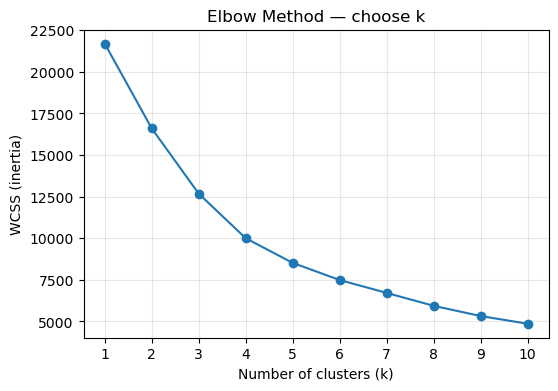

In [25]:
# Elbow Method to choose k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)   # <-- reuse from Cell 6
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (inertia)')
plt.title('Elbow Method — choose k')
plt.xticks(K_range)
plt.grid(alpha=0.3)
plt.show()



In [31]:
# Cell 10: Run KMeans with optimal k (4)
from sklearn.cluster import KMeans

optimal_k = 4  # chosen from elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster counts:")
print(rfm['Cluster'].value_counts())


C:\Users\fatim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


Cluster counts:
Cluster
2    2733
0    1042
1     549
3      14
Name: count, dtype: int64


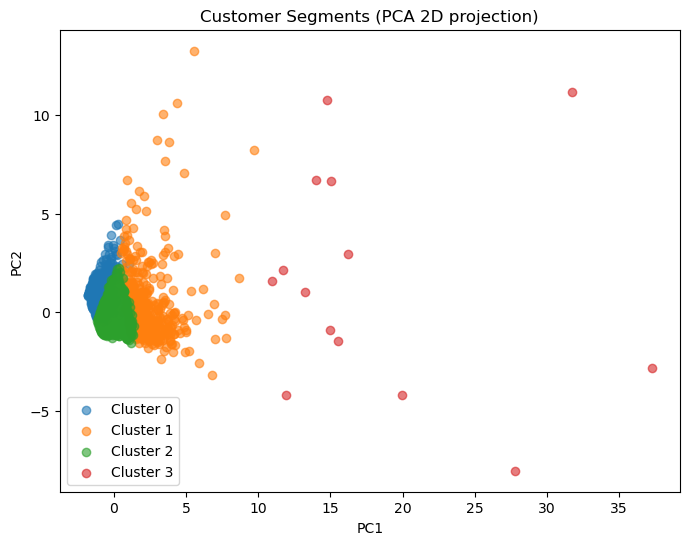

In [33]:
# Cell 11: Visualize clusters using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce scaled features to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for c in sorted(rfm['Cluster'].unique()):
    plt.scatter(X_pca[rfm['Cluster']==c, 0],
                X_pca[rfm['Cluster']==c, 1],
                label=f"Cluster {c}", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Segments (PCA 2D projection)")
plt.legend()
plt.show()


        Recency               Frequency                Monetary            \
           mean median    std      mean median    std      mean    median   
Cluster                                                                     
0        250.27  246.0  65.63      1.57    1.0   1.47    420.97    304.25   
1         27.54   14.0  39.14     11.92    9.0  10.35   6035.91   4263.92   
2         45.90   35.0  37.11      3.36    3.0   2.70    991.23    695.20   
3          4.64    2.5   6.21     83.29   66.5  59.98  75700.23  58748.66   

                  AvgOrderValue                   UniqueProducts         \
              std          mean   median      std           mean median   
Cluster                                                                   
0          501.06        276.32   214.80   217.46          23.54   17.0   
1         5922.71        706.82   506.47   646.13         183.64  172.0   
2          914.11        305.72   272.29   180.08          47.46   37.0   
3        5

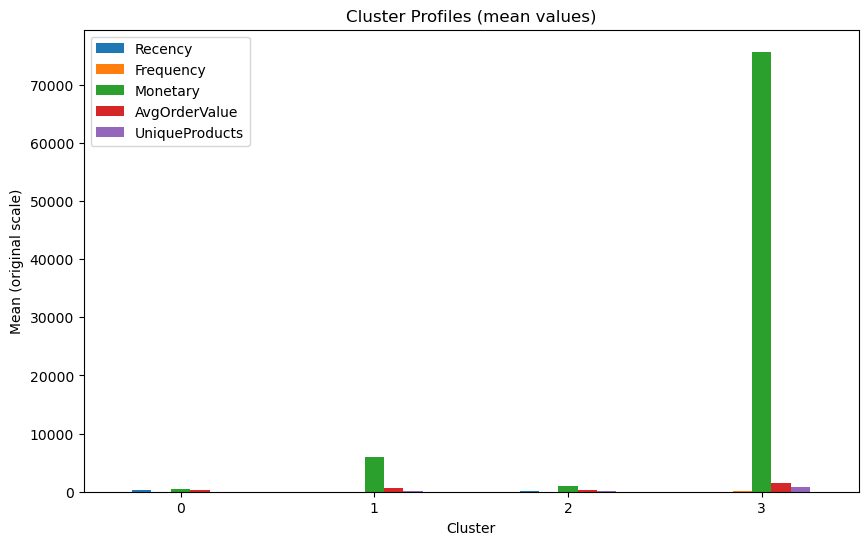

In [35]:
# Cell 12: Cluster summary profiles
features = ['Recency','Frequency','Monetary','AvgOrderValue','UniqueProducts']

# Summary stats per cluster
cluster_summary = rfm.groupby('Cluster')[features].agg(['mean','median','std']).round(2)
print(cluster_summary)

# Mean profiles (bar plot)
rfm_means = rfm.groupby('Cluster')[features].mean()

rfm_means.plot(kind='bar', figsize=(10,6))
plt.title("Cluster Profiles (mean values)")
plt.ylabel("Mean (original scale)")
plt.xticks(rotation=0)
plt.show()


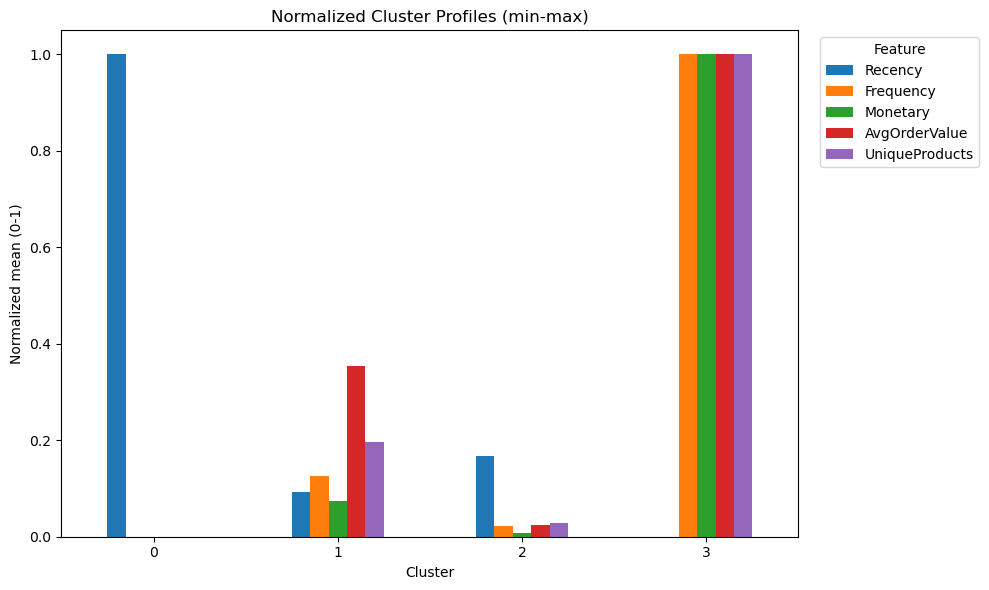


Normalized cluster means (0-1):


,Recency,Frequency,Monetary,AvgOrderValue,UniqueProducts
Cluster,,,,,
0,1.000,0.000,0.000,0.000,0.000
1,0.093,0.127,0.075,0.353,0.197
2,0.168,0.022,0.008,0.024,0.029
3,0.000,1.000,1.000,1.000,1.000


In [37]:
# Normalized cluster profiles (min-max per feature across clusters)

# Cluster means (original scale)
cluster_means = rfm.groupby('Cluster')[features].mean()

# Min-max normalize per feature across clusters [0,1]
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Plot
cluster_means_norm.plot(kind='bar', figsize=(10,6))
plt.ylabel('Normalized mean (0-1)')
plt.title('Normalized Cluster Profiles (min-max)')
plt.xticks(rotation=0)
plt.legend(title='Feature', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nNormalized cluster means (0-1):")
display(cluster_means_norm.round(3))


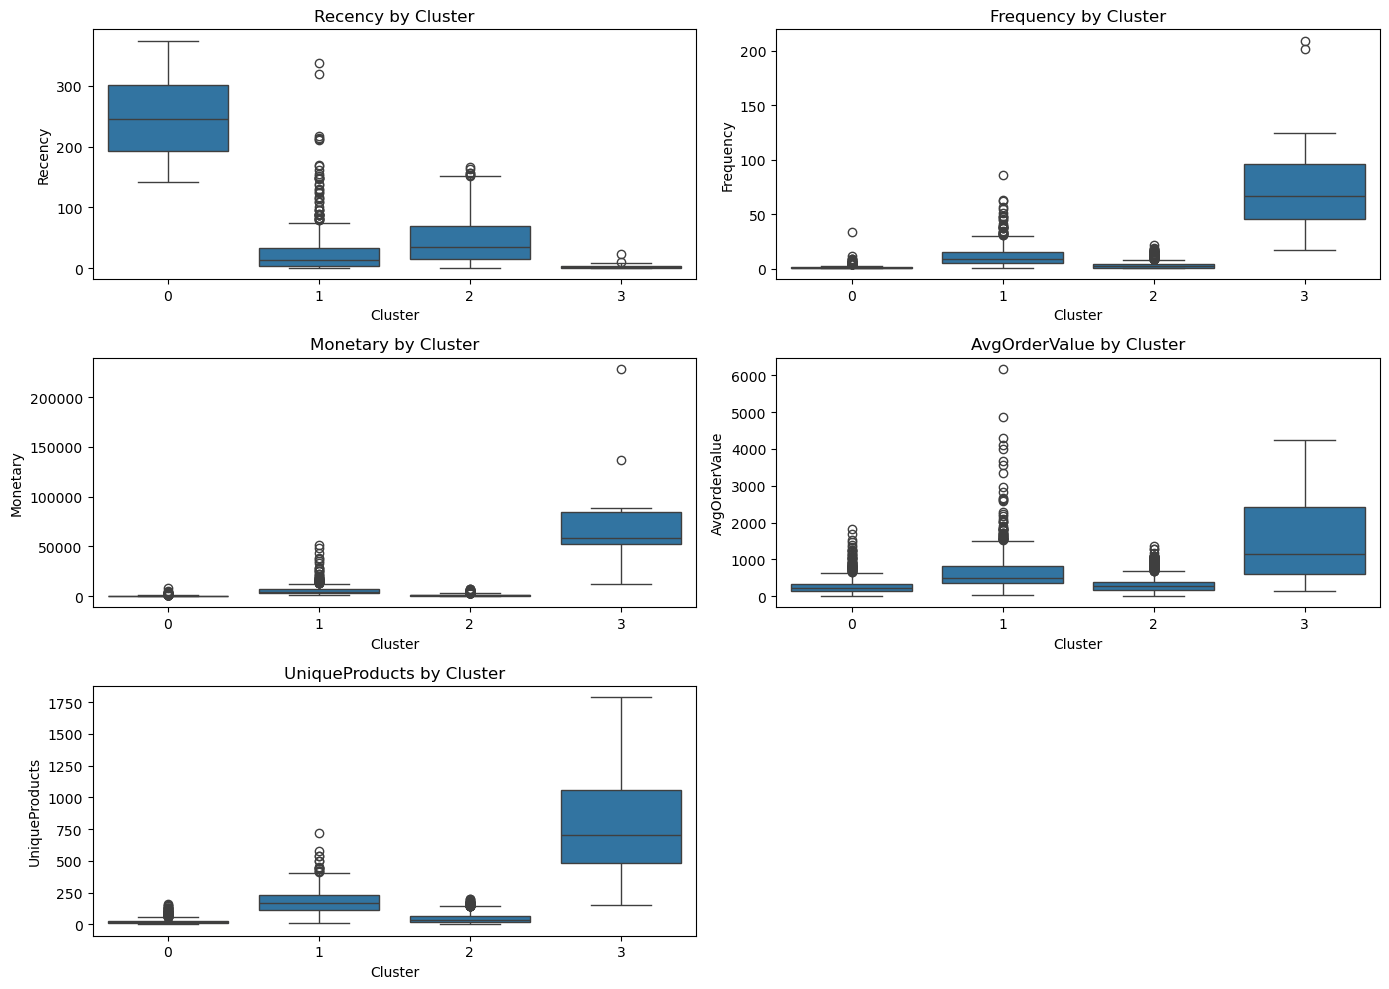

In [39]:
# Boxplots to see spread of features within each cluster
plt.figure(figsize=(14,10))

for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Cluster', y=col, data=rfm)
    plt.title(f"{col} by Cluster")
    plt.xlabel("Cluster")
    plt.tight_layout()

plt.show()
